In [1]:
# !pip install pytorch-fid
!pip install einops

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 2.0 MB/s eta 0:00:00


In [2]:
import torch
import math
import torch.nn as nn
import numpy as np
import os
import cv2
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import torch.optim as optim
import pickle
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
from sklearn.cluster import KMeans
# from pytorch_fid.fid_score import calculate_fid_given_paths
import torch.optim as optim
import time

In [3]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
class ScaleShiftSelectTransform:
    def __call__(self, img):
        img_tensor = transforms.ToTensor()(img)
        if img_tensor.shape[0] > 3:
            img_tensor = img_tensor[:3, :, :]
        return 2 * img_tensor - 1
  

transform3 = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images to 128x128 pixels
    ScaleShiftSelectTransform()  # Combined custom transform
])


transform1 = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images to 128x128 pixels
    transforms.ToTensor(),  # Convert images to PyTorch tensors with values in [0, 1]
    transforms.Normalize(mean=[0.5, 0.5, 0.5,0.5], std=[0.5, 0.5, 0.5,0.5])  # Normalize images to have values in [-1, 1]
    
])
transform2 = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images to 128x128 pixels
    transforms.ToTensor(),  # Convert images to PyTorch tensors with values in [0, 1]
#     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize images to have values in [-1, 1]
])

class dataset(Dataset):
    def __init__(self,path_x,path_y):
        self.path_x=path_x
        self.path_y=path_y
        self.x_imgs=sorted(os.listdir(path_x))
        self.y_imgs=sorted(os.listdir(path_y))
    def __len__(self):
        return len(self.x_imgs)
    
    def __getitem__(self,i):
        x_img_path=os.path.join(self.path_x,self.x_imgs[i])
        y_img_path=os.path.join(self.path_y,self.y_imgs[i])
#         print(x_img_path,y_img_path)
#         temp=Image.open(x_img_path)
#         print(np.array(temp).shape)
#         img_x=transform1(Image.open(x_img_path).convert("RGB"))
#         img_x=transform1(Image.open(x_img_path)) ## changed from above removed rgb taken 4 layers
        img_x=transform3(Image.open(x_img_path)) 
        img_y=transform2(Image.open(y_img_path))
        
        return img_x,img_y

In [5]:
def show_img(image_tensor):
    rgb_image_tensor = image_tensor[:3]
    image_array = rgb_image_tensor.numpy()
    plt.imshow(image_array.transpose(1, 2, 0))
    plt.axis('off')
    plt.show()

In [6]:
x_pth_train="/kaggle/input/deeplearning-ass2/dataset/images/train"
y_pth_train="/kaggle/input/deeplearning-ass2/dataset/masks/train"
x_pth_val="/kaggle/input/deeplearning-ass2/dataset/images/val"
y_pth_val="/kaggle/input/deeplearning-ass2/dataset/masks/val"
data_train=dataset(x_pth_train,y_pth_train)
data_val=dataset(x_pth_val,y_pth_val)
train_loader = DataLoader(data_train, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(data_val, batch_size=32, shuffle=False, num_workers=4)

In [7]:
# x,y=data_train[10]
# show_img(x)
# show_img(y)
# print(x.shape,y.shape)
# for x,y in train_loader:
#     print(x.shape,y.shape)
#     break

In [8]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np

# taming.modules.vqvae.quantize

import numpy as np

import torch
import torch.nn as nn

from einops import rearrange


class VectorQuantizer(nn.Module):
    """
    Improved version over VectorQuantizer, can be used as a drop-in replacement. Mostly
    avoids costly matrix multiplications and allows for post-hoc remapping of indices.
    """

    # NOTE: due to a bug the beta term was applied to the wrong term. for
    # backwards compatibility we use the buggy version by default, but you can
    # specify legacy=False to fix it.
    def __init__(
        self,
        n_e,
        e_dim,
        beta,
        remap=None,
        unknown_index="random",
        sane_index_shape=False,
        legacy=True,
    ):
        super().__init__()
        self.n_e = n_e
        self.e_dim = e_dim
        self.beta = beta
        self.legacy = legacy

        self.embedding = nn.Embedding(self.n_e, self.e_dim)
        self.embedding.weight.data.uniform_(-1.0 / self.n_e, 1.0 / self.n_e)

        self.remap = remap
        if self.remap is not None:
            self.register_buffer("used", torch.tensor(np.load(self.remap)))
            self.re_embed = self.used.shape[0]
            self.unknown_index = unknown_index  # "random" or "extra" or integer
            if self.unknown_index == "extra":
                self.unknown_index = self.re_embed
                self.re_embed = self.re_embed + 1
            print(f"Remapping {self.n_e} indices to {self.re_embed} indices. "
                  f"Using {self.unknown_index} for unknown indices.")
        else:
            self.re_embed = n_e

        self.sane_index_shape = sane_index_shape

    def remap_to_used(self, inds):
        ishape = inds.shape
        assert len(ishape) > 1
        inds = inds.reshape(ishape[0], -1)
        used = self.used.to(inds)
        match = (inds[:, :, None] == used[None, None, ...]).long()
        new = match.argmax(-1)
        unknown = match.sum(2) < 1
        if self.unknown_index == "random":
            new[unknown] = torch.randint(
                0, self.re_embed,
                size=new[unknown].shape).to(device=new.device)
        else:
            new[unknown] = self.unknown_index
        return new.reshape(ishape)

    def unmap_to_all(self, inds):
        ishape = inds.shape
        assert len(ishape) > 1
        inds = inds.reshape(ishape[0], -1)
        used = self.used.to(inds)
        if self.re_embed > self.used.shape[0]:  # extra token
            inds[inds >= self.used.shape[0]] = 0  # simply set to zero
        back = torch.gather(used[None, :][inds.shape[0] * [0], :], 1, inds)
        return back.reshape(ishape)

    def forward(self, z, temp=None, rescale_logits=False, return_logits=False):
        assert temp is None or temp == 1.0, "Only for interface compatible with Gumbel"
        assert rescale_logits == False, "Only for interface compatible with Gumbel"
        assert return_logits == False, "Only for interface compatible with Gumbel"
        # reshape z -> (batch, height, width, channel) and flatten
        z = rearrange(z, 'b c h w -> b h w c').contiguous()
        z_flattened = z.view(-1, self.e_dim)
        # distances from z to embeddings e_j (z - e)^2 = z^2 + e^2 - 2 e * z

        d = torch.sum(z_flattened ** 2, dim=1, keepdim=True) + \
            torch.sum(self.embedding.weight**2, dim=1) - 2 * \
            torch.einsum('bd,dn->bn', z_flattened, rearrange(self.embedding.weight, 'n d -> d n'))

        min_encoding_indices = torch.argmin(d, dim=1)
        z_q = self.embedding(min_encoding_indices).view(z.shape)
        perplexity = None
        min_encodings = None

        # compute loss for embedding
        if not self.legacy:
            loss = self.beta * torch.mean((z_q.detach()-z)**2) + \
                   torch.mean((z_q - z.detach()) ** 2)
        else:
            loss = torch.mean((z_q.detach()-z)**2) + self.beta * \
                   torch.mean((z_q - z.detach()) ** 2)

        # preserve gradients
        z_q = z + (z_q - z).detach()

        # reshape back to match original input shape
        z_q = rearrange(z_q, 'b h w c -> b c h w').contiguous()

        if self.remap is not None:
            min_encoding_indices = min_encoding_indices.reshape(
                z.shape[0], -1)  # add batch axis
            min_encoding_indices = self.remap_to_used(min_encoding_indices)
            min_encoding_indices = min_encoding_indices.reshape(-1,
                                                                1)  # flatten

        if self.sane_index_shape:
            min_encoding_indices = min_encoding_indices.reshape(
                z_q.shape[0], z_q.shape[2], z_q.shape[3])

        return z_q, loss, (perplexity, min_encodings, min_encoding_indices)

    def get_codebook_entry(self, indices, shape):
        # shape specifying (batch, height, width, channel)
        if self.remap is not None:
            indices = indices.reshape(shape[0], -1)  # add batch axis
            indices = self.unmap_to_all(indices)
            indices = indices.reshape(-1)  # flatten again

        # get quantized latent vectors
        z_q = self.embedding(indices)

        if shape is not None:
            z_q = z_q.view(shape)
            # reshape back to match original input shape
            z_q = z_q.permute(0, 3, 1, 2).contiguous()

        return z_q

def nonlinearity(x):
    # swish
    return x * torch.sigmoid(x)


def Normalize(in_channels, num_groups=32):
    return torch.nn.GroupNorm(
        num_groups=num_groups, num_channels=in_channels, eps=1e-6, affine=True)


class Upsample(nn.Module):

    def __init__(self, in_channels, with_conv):
        super().__init__()
        self.with_conv = with_conv
        if self.with_conv:
            self.conv = torch.nn.Conv2d(
                in_channels, in_channels, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        x = torch.nn.functional.interpolate(
            x, scale_factor=2.0, mode="nearest")
        if self.with_conv:
            x = self.conv(x)
        return x


class Downsample(nn.Module):

    def __init__(self, in_channels, with_conv):
        super().__init__()
        self.with_conv = with_conv
        if self.with_conv:
            # no asymmetric padding in torch conv, must do it ourselves
            self.conv = torch.nn.Conv2d(
                in_channels, in_channels, kernel_size=3, stride=2, padding=0)

    def forward(self, x):
        if self.with_conv:
            pad = (0, 1, 0, 1)
            x = torch.nn.functional.pad(x, pad, mode="constant", value=0)
            x = self.conv(x)
        else:
            x = torch.nn.functional.avg_pool2d(x, kernel_size=2, stride=2)
        return x


class ResnetBlock(nn.Module):

    def __init__(
        self,
        *,
        in_channels,
        out_channels=None,
        conv_shortcut=False,
        dropout,
    ):
        super().__init__()
        self.in_channels = in_channels
        out_channels = in_channels if out_channels is None else out_channels
        self.out_channels = out_channels
        self.use_conv_shortcut = conv_shortcut

        self.norm1 = Normalize(in_channels)
        self.conv1 = torch.nn.Conv2d(
            in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.norm2 = Normalize(out_channels)
        self.dropout = torch.nn.Dropout(dropout)
        self.conv2 = torch.nn.Conv2d(
            out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        if self.in_channels != self.out_channels:
            if self.use_conv_shortcut:
                self.conv_shortcut = torch.nn.Conv2d(
                    in_channels,
                    out_channels,
                    kernel_size=3,
                    stride=1,
                    padding=1)
            else:
                self.nin_shortcut = torch.nn.Conv2d(
                    in_channels,
                    out_channels,
                    kernel_size=1,
                    stride=1,
                    padding=0)

    def forward(self, x):
        h = x
        h = self.norm1(h)
        h = nonlinearity(h)
        h = self.conv1(h)

        h = self.norm2(h)
        h = nonlinearity(h)
        h = self.dropout(h)
        h = self.conv2(h)

        if self.in_channels != self.out_channels:
            if self.use_conv_shortcut:
                x = self.conv_shortcut(x)
            else:
                x = self.nin_shortcut(x)

        return x + h


class AttnBlock(nn.Module):

    def __init__(self, in_channels):
        super().__init__()
        self.in_channels = in_channels

        self.norm = Normalize(in_channels)
        self.q = torch.nn.Conv2d(
            in_channels, in_channels, kernel_size=1, stride=1, padding=0)
        self.k = torch.nn.Conv2d(
            in_channels, in_channels, kernel_size=1, stride=1, padding=0)
        self.v = torch.nn.Conv2d(
            in_channels, in_channels, kernel_size=1, stride=1, padding=0)
        self.proj_out = torch.nn.Conv2d(
            in_channels, in_channels, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        h_ = x
        h_ = self.norm(h_)
        q = self.q(h_)
        k = self.k(h_)
        v = self.v(h_)

        # compute attention
        b, c, h, w = q.shape
        q = q.reshape(b, c, h * w)
        q = q.permute(0, 2, 1)  # b,hw,c
        k = k.reshape(b, c, h * w)  # b,c,hw
        w_ = torch.bmm(q, k)  # b,hw,hw    w[b,i,j]=sum_c q[b,i,c]k[b,c,j]
        w_ = w_ * (int(c)**(-0.5))
        w_ = torch.nn.functional.softmax(w_, dim=2)

        # attend to values
        v = v.reshape(b, c, h * w)
        w_ = w_.permute(0, 2, 1)  # b,hw,hw (first hw of k, second of q)
        h_ = torch.bmm(
            v, w_)  # b, c,hw (hw of q) h_[b,c,j] = sum_i v[b,c,i] w_[b,i,j]
        h_ = h_.reshape(b, c, h, w)

        h_ = self.proj_out(h_)

        return x + h_


def make_attn(in_channels, attn_type="vanilla"):
    assert attn_type in ["vanilla", "none"], f'attn_type {attn_type} unknown'
    print(f"making '{attn_type}' attention with {in_channels} in_channels")
    if attn_type == "vanilla":
        return AttnBlock(in_channels)
    elif attn_type == "none":
        return nn.Identity(in_channels)
    else:
        raise NotImplementedError(f'attn_type {attn_type} not implemented')


class Encoder(nn.Module):

    def __init__(
        self,
        *,
        ch,
        out_ch,
        ch_mult=(1, 2, 4, 8),
        num_res_blocks,
        attn_resolutions,
        dropout=0.0,
        resamp_with_conv=True,
        in_channels,
        resolution,
        z_channels,
        double_z=False,
        attn_type="vanilla",
        **ignore_kwargs,
    ):
        super().__init__()

        self.ch = ch
        self.num_resolutions = len(ch_mult)
        self.num_res_blocks = num_res_blocks
        self.resolution = resolution
        self.in_channels = in_channels

        # downsampling
        self.conv_in = torch.nn.Conv2d(
            in_channels, self.ch, kernel_size=3, stride=1, padding=1)

        curr_res = resolution
        in_ch_mult = (1, ) + tuple(ch_mult)
        self.in_ch_mult = in_ch_mult
        self.down = nn.ModuleList()
        for i_level in range(self.num_resolutions):
            block = nn.ModuleList()
            attn = nn.ModuleList()
            block_in = ch * in_ch_mult[i_level]
            block_out = ch * ch_mult[i_level]
            for i_block in range(self.num_res_blocks):
                block.append(
                    ResnetBlock(
                        in_channels=block_in,
                        out_channels=block_out,
                        dropout=dropout))
                block_in = block_out
                if curr_res in attn_resolutions:
                    attn.append(make_attn(block_in, attn_type=attn_type))
            down = nn.Module()
            down.block = block
            down.attn = attn
            if i_level != self.num_resolutions - 1:
                down.downsample = Downsample(block_in, resamp_with_conv)
                curr_res = curr_res // 2
            self.down.append(down)

        # middle
        self.mid = nn.Module()
        self.mid.block_1 = ResnetBlock(
            in_channels=block_in, out_channels=block_in, dropout=dropout)
        self.mid.attn_1 = make_attn(block_in, attn_type=attn_type)
        self.mid.block_2 = ResnetBlock(
            in_channels=block_in, out_channels=block_in, dropout=dropout)

        # end
        self.norm_out = Normalize(block_in)
        out_ch = z_channels * 2 if double_z else z_channels
        self.conv_out = torch.nn.Conv2d(
            block_in, out_ch, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        # downsampling
        hs = [self.conv_in(x)]
        for i_level in range(self.num_resolutions):
            for i_block in range(self.num_res_blocks):
                h = self.down[i_level].block[i_block](hs[-1])
                if len(self.down[i_level].attn) > 0:
                    h = self.down[i_level].attn[i_block](h)
                hs.append(h)
            if i_level != self.num_resolutions - 1:
                hs.append(self.down[i_level].downsample(hs[-1]))

        # middle
        h = hs[-1]
        h = self.mid.block_1(h)
        h = self.mid.attn_1(h)
        h = self.mid.block_2(h)

        # end
        h = self.norm_out(h)
        h = nonlinearity(h)
        h = self.conv_out(h)
        return h


class Decoder(nn.Module):

    def __init__(
        self,
        *,
        ch,
        out_ch,
        ch_mult=(1, 2, 4, 8),
        num_res_blocks,
        attn_resolutions,
        dropout=0.0,
        resamp_with_conv=True,
        in_channels,
        resolution,
        z_channels,
        attn_type="vanilla",
        **ignorekwargs,
    ):
        super().__init__()

        self.ch = ch
        self.num_resolutions = len(ch_mult)
        self.num_res_blocks = num_res_blocks
        self.resolution = resolution
        self.in_channels = in_channels

        # compute in_ch_mult, block_in and curr_res at lowest res
        in_ch_mult = (1, ) + tuple(ch_mult)
        block_in = ch * ch_mult[self.num_resolutions - 1]
        curr_res = resolution // 2**(self.num_resolutions - 1)
        self.z_shape = (1, z_channels, curr_res, curr_res)
        print("Working with z of shape {} = {} dimensions.".format(
            self.z_shape, np.prod(self.z_shape)))

        # z to block_in
        self.conv_in = torch.nn.Conv2d(
            z_channels, block_in, kernel_size=3, stride=1, padding=1)

        # middle
        self.mid = nn.Module()
        self.mid.block_1 = ResnetBlock(
            in_channels=block_in, out_channels=block_in, dropout=dropout)
        self.mid.attn_1 = make_attn(block_in, attn_type=attn_type)
        self.mid.block_2 = ResnetBlock(
            in_channels=block_in, out_channels=block_in, dropout=dropout)

        # upsampling
        self.up = nn.ModuleList()
        for i_level in reversed(range(self.num_resolutions)):
            block = nn.ModuleList()
            attn = nn.ModuleList()
            block_out = ch * ch_mult[i_level]
            for i_block in range(self.num_res_blocks + 1):
                block.append(
                    ResnetBlock(
                        in_channels=block_in,
                        out_channels=block_out,
                        dropout=dropout))
                block_in = block_out
                if curr_res in attn_resolutions:
                    attn.append(make_attn(block_in, attn_type=attn_type))
            up = nn.Module()
            up.block = block
            up.attn = attn
            if i_level != 0:
                up.upsample = Upsample(block_in, resamp_with_conv)
                curr_res = curr_res * 2
            self.up.insert(0, up)  # prepend to get consistent order

        # end
        self.norm_out = Normalize(block_in)
        self.conv_out = torch.nn.Conv2d(
            block_in, out_ch, kernel_size=3, stride=1, padding=1)

    def forward(self, z):
        # assert z.shape[1:] == self.z_shape[1:]
        self.last_z_shape = z.shape

        # z to block_in
        h = self.conv_in(z)

        # middle
        h = self.mid.block_1(h)
        h = self.mid.attn_1(h)
        h = self.mid.block_2(h)

        # upsampling
        for i_level in reversed(range(self.num_resolutions)):
            for i_block in range(self.num_res_blocks + 1):
                h = self.up[i_level].block[i_block](h)
                if len(self.up[i_level].attn) > 0:
                    h = self.up[i_level].attn[i_block](h)
            if i_level != 0:
                h = self.up[i_level].upsample(h)

        h = self.norm_out(h)
        h = nonlinearity(h)
        h = self.conv_out(h)
        return h


def temporal_wrapper(func):
    """A wrapper to make the model compatible with both 4D and 5D inputs."""

    def f(cls, x):
        """x is either [B, C, H, W] or [B, T, C, H, W]."""
        B = x.shape[0]
        if len(x.shape) == 5:
            unflatten = True
            x = x.flatten(0, 1)
        else:
            unflatten = False

        outs = func(cls, x)

        if unflatten:
            if isinstance(outs, tuple):
                outs = [o.unflatten(0, (B, -1)) if o.ndim else o for o in outs]
                return tuple(outs)
            else:
                return outs.unflatten(0, (B, -1))
        else:
            return outs

    return f


class VAE(torch.nn.Module):
    """VQ-VAE consisting of Encoder, QuantizationLayer and Decoder."""

    def __init__(
        self,
        enc_dec_dict=dict(
            resolution=128,
            in_channels=3,
            z_channels=3,
            ch=64,  # base_channel
            ch_mult=[1, 2, 4],  # num_down = len(ch_mult)-1
            num_res_blocks=2,
            attn_resolutions=[],
            out_ch=3,
            dropout=0.0,
        ),
        vq_dict=dict(
            n_embed=4096,  # vocab_size
            embed_dim=3,  # same as `z_channels`
            percept_loss_w=1.0,
        ),
        use_loss=True,
    ):
        super().__init__()

        self.resolution = enc_dec_dict['resolution']
        self.embed_dim = vq_dict['embed_dim']
        self.n_embed = vq_dict['n_embed']
        self.z_ch = enc_dec_dict['z_channels']

        self.encoder = Encoder(**enc_dec_dict)
        self.decoder = Decoder(**enc_dec_dict)

        self.quantize = VectorQuantizer(
            self.n_embed,
            self.embed_dim,
            beta=0.25,
            sane_index_shape=True,
        )
        self.quant_conv = nn.Conv2d(self.z_ch, self.embed_dim, 1)
        self.post_quant_conv = nn.Conv2d(self.embed_dim, self.z_ch, 1)

        # if use_loss:
        #     self.loss = VQLPIPSLoss(percept_loss_w=vq_dict['percept_loss_w'])

    @temporal_wrapper
    def encode_quantize(self, x):
        """Encode image to pre-VQ features, then quantize."""
        h = self.encode(x)  # `embed_dim`
        quant, quant_loss, (_, _, quant_idx) = self.quantize(h)
        # [B, `embed_dim`, h, w], scalar, [B*h*w]
        return quant, quant_loss, quant_idx

    @temporal_wrapper
    def encode(self, x):
        """Encode image to pre-VQ features."""
        # this is the x0 in LDM!
        h = self.encoder(x)  # `z_ch`
        h = self.quant_conv(h)  # `embed_dim`
        return h
    
    def decode(self, latent):
        quant, quant_loss, (_, _, quant_idx) = self.quantize(latent)
        image = self._decode(quant)
        return image

    @temporal_wrapper
    def quantize_decode(self, h):
        """Input pre-VQ features, quantize and decode to reconstruct."""
        # use this to reconstruct images from LDM's denoised output!
        quant, _, _ = self.quantize(h)
        dec = self.decode(quant)
        return dec

    @temporal_wrapper
    def _decode(self, quant):
        """Input already quantized features, do reconstruction."""
        quant = self.post_quant_conv(quant)  # `z_ch`
        dec = self.decoder(quant)
        return dec

    def forward(self, data_dict):
        img = data_dict['img']
        quant, quant_loss, token_id = self.encode_quantize(img)
        recon = self.decode(quant)
        out_dict = {
            'recon': recon,
            'token_id': token_id,
            'quant_loss': quant_loss,
        }
        return out_dict

    def calc_train_loss(self, data_dict, out_dict):
        """Compute training loss."""
        img = data_dict['img']
        recon = out_dict['recon']
        quant_loss = out_dict['quant_loss']

        loss_dict = self.loss(quant_loss, img, recon)

        return loss_dict

    @torch.no_grad()
    def calc_eval_loss(self, data_dict, out_dict):
        """Loss computation in eval."""
        loss_dict = self.calc_train_loss(data_dict, out_dict)
        img = data_dict['img']
        recon = out_dict['recon']
        loss_dict['recon_mse'] = F.mse_loss(recon, img)
        return loss_dict

    @property
    def dtype(self):
        return self.quant_conv.weight.dtype

    @property
    def device(self):
        return self.quant_conv.weight.device



In [9]:
class PositionalEmbedding(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.input_dim = input_dim
        
        self.linear = nn.Linear(4, input_dim)

    def forward(self, cnn_feature_maps):
#         print("cnn feature map : ",cnn_feature_maps.shape)
        batch_size,_,height,width = cnn_feature_maps.shape
        
        # Construct positional embeddings tensor
        positional_embeddings = torch.zeros(batch_size, height, width, 4).to(device)
        for i in range(height):
            for j in range(width):
                positional_embeddings[:, i, j, 0] = j / (width - 1)  # Left
                positional_embeddings[:, i, j, 1] = i / (height - 1)  # Top
                positional_embeddings[:, i, j, 2] = (width - 1 - j) / (width - 1)  # Right
                positional_embeddings[:, i, j, 3] = (height - 1 - i) / (height - 1)  # Bottom
#         print(positional_embeddings[0,:,:,:])
#         print("before linear : ",positional_embeddings.shape)
        # Project positional embeddings to the same dimensionality as image feature vectors
        positional_embeddings = self.linear(positional_embeddings.view(batch_size * height * width, 4))
#         print("after linear : ",positional_embeddings.shape)
        positional_embeddings = positional_embeddings.view(batch_size, height, width, self.input_dim)
#         print("after reshape : ",positional_embeddings.shape)
        # Add positional embeddings to the original CNN feature maps
        augmented_feature_maps = cnn_feature_maps + positional_embeddings.view(batch_size,self.input_dim, height, width)
#         print("augmented_feature_maps: ",augmented_feature_maps.shape)
        return augmented_feature_maps

In [10]:
class encoder(nn.Module):
    def __init__(self,hid_dim=32):
        super().__init__()
        #self.conv1=nn.Conv2d(4,32,3,padding=1)
        #self.conv2=nn.conv2d(32,32,3,padding=1)
        #self.conv3=nn.conv2d(32,32,3,padding=1)
        self.conv1=nn.Conv2d(3,hid_dim,5,padding=2)  ############################### changed from 3 to 4
        self.conv2=nn.Conv2d(hid_dim,hid_dim,5,padding=2,stride=2)
        self.conv3=nn.Conv2d(hid_dim,hid_dim,5,padding=2,stride=2)
        self.conv4=nn.Conv2d(hid_dim,hid_dim,5,padding=2)
        self.nn1=nn.Linear(hid_dim,hid_dim)
        self.nn2=nn.Linear(hid_dim,hid_dim)
        self.layernorm=nn.LayerNorm(hid_dim)
#         print(hid_dim)
        self.position_embedding=PositionalEmbedding(input_dim=hid_dim)
    def forward(self,x):
#         print("input :",x.shape)
        x=self.conv1(x)
        x = F.relu(x)##################################################
        x = self.conv2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = F.relu(x)
#         print("conv out",x.shape)
        x=self.position_embedding(x) #x_with_position_embedding
        x=(torch.flatten(x,2,3)).permute(0,2,1) #x_flatten
        x=self.layernorm(x) #layer_norm_out
        x=self.nn2(F.relu(self.nn1(x))) #final_x
        
#         print("final encoder out : ",x.shape)
#         print("flatten : ",torch.flatten(x_with_position_embedding,2,3).shape)
        return x

In [11]:
class slot_attention(nn.Module):
    def __init__(self,hid_dim=64,k=11,iterations=3):
        super().__init__()
        self.layernorm=nn.LayerNorm(hid_dim)
        self.mu=nn.Parameter(torch.randn(1, 1, hid_dim))
        self.sigma=nn.Parameter(torch.rand(1, 1, hid_dim))
        self.k=k
        self.iterations=iterations
        self.q_matrix=nn.Linear(hid_dim,hid_dim)
        self.k_matrix=nn.Linear(hid_dim,hid_dim)
        self.v_matrix=nn.Linear(hid_dim,hid_dim)
        self.layernorm_slot1=nn.LayerNorm(hid_dim)
        self.layernorm_slot2=nn.LayerNorm(hid_dim)
        self.gru=nn.GRUCell(hid_dim,hid_dim)
        self.ff=nn.Linear(hid_dim,hid_dim)
    def forward(self,encoder_out):
#         print("encoder_out : ",encoder_out.shape)
        layernorm_out=self.layernorm(encoder_out)
#         print("layernorm_out shape :",layernorm_out.shape)
        b,n,d=layernorm_out.shape
        
        mu = self.mu.expand(b, self.k, -1)
        sigma = self.sigma.expand(b, self.k, -1)
#         print(f"mu shape : {mu.shape} sigma shape {sigma.shape}")
#         print(torch.min(mu),torch.max(mu),torch.min(sigma),torch.max(sigma))
        slots= torch.normal(mu,sigma)
#         print("slot shape : ",slots.shape)
        k_out=self.k_matrix(layernorm_out)
        v_out=self.v_matrix(layernorm_out)
        for i in range(self.iterations):
            slot_previous=slots.clone()
            slots=self.layernorm_slot1(slots)
            
           
            q_out=self.q_matrix(slots)
            
#             print(f"k_out : {k_out.shape} q_out : {q_out.shape} v_out : {v_out.shape}")
            
            attention_weights=(torch.einsum('bid,bjd->bij', k_out, q_out) * (d ** -0.5)).softmax(dim=2)+(1e-8)
#             print(f"attention_weights : {attention_weights.shape}")
            attention_weights = attention_weights / attention_weights.sum(dim=1, keepdim=True)
#             print(f"attention_weights after normalize : {attention_weights.shape}")
            updates=torch.einsum('bnd,bnk->bkd', v_out, attention_weights)
#             print(f"updates : {updates.shape}")
            slots=(self.gru(updates.reshape(-1,d),slot_previous.reshape(-1,d))).reshape(b,-1,d)
#             print(f"slots : {slots.shape}")
            slots=F.relu(self.ff(self.layernorm_slot2(slots)))+slots
            
#             break
#         print(f"final_out slot attention  : {slots.shape}")
        return slots
        
        

In [12]:
class slot_model(nn.Module):
    def __init__(self,hid_dim=64,output_channels=4,img_height=128):
        super().__init__()
        self.encoder=encoder(hid_dim=hid_dim)
        self.slot_att=slot_attention(hid_dim=hid_dim)
        self.softmax = nn.Softmax(dim=1)
    def forward(self,x):
        b,d,h,w=x.shape
        enc_out=self.encoder(x)
        slots=self.slot_att(enc_out)
        return slots
        

# check norm we used layer norm in residual blocks

In [13]:
class self_attention(nn.Module):
    def __init__(self,in_dim=64,hid_dim=64,num_heads=None):
        super().__init__()
        self.hid_dim=hid_dim
        self.k=nn.Linear(in_dim,hid_dim)
        self.q=nn.Linear(in_dim,hid_dim)
        self.v=nn.Linear(in_dim,hid_dim)
        self.ff=nn.Linear(hid_dim,in_dim)
    def forward(self,x,mask=True):# x-> bx(hxw)xf
        b,l,input_dim=x.shape
        k,q,v=self.k(x),self.q(x),self.v(x)
#         print(f"k ,q ,v {k.shape} ,{q.shape} ,{v.shape}")
        scores=q@k.permute(0,2,1)
        if(mask):
            scores.masked_fill_(torch.ones_like(scores, dtype=torch.bool).triu(1) , -torch.inf)
        scores=scores/(self.hid_dim ** (0.5))
        scores=scores.softmax(dim=2)
        z=self.ff(scores @ v)
#         print("attention out ",z.shape)
        return z
    

        

class cross_attention(nn.Module):
    def __init__(self,in_dim=64,hid_dim=64,num_heads=None):
        super().__init__()
        self.hid_dim=hid_dim
        self.k=nn.Linear(in_dim,hid_dim)
        self.q=nn.Linear(in_dim,hid_dim)
        self.v=nn.Linear(in_dim,hid_dim)
        self.ff=nn.Linear(hid_dim,in_dim)
    def forward(self,x,y):
        b,l,input_dim=x.shape
        k,q,v=self.k(y),self.q(x),self.v(y)
#         print(f"k ,q ,v {k.shape} ,{q.shape} ,{v.shape}")
        scores=q@k.permute(0,2,1)
        scores=scores/(self.hid_dim ** (0.5))
        scores=scores.softmax(dim=2)
        z=self.ff(scores @ v)
#         print("cross attention out ",z.shape)
        return z
        


class resblock(nn.Module):
    def __init__(self,in_dim=64,out_dim=64,dropout=0.5,stride=1,in_time=1280,num_groups=4):  ###check arg intime and other
        super().__init__()
        self.norm1=nn.GroupNorm(num_groups,in_dim)
        self.norm2=nn.GroupNorm(num_groups,out_dim)
        self.conv1=nn.Conv2d(in_dim,out_dim,3,padding=1,stride=stride)
        self.conv2=nn.Conv2d(out_dim,out_dim,3,padding=1,stride=stride)
        self.ff1=nn.Linear(in_time,out_dim)
        self.dropout=nn.Dropout(dropout)
    def forward(self,x,t):
        x=self.conv1(F.selu(self.norm1(x.permute(0,3,1,2)))).permute(0,2,3,1)
        t=self.ff1(F.selu(t)).unsqueeze(1).unsqueeze(1)
#         print(x.shape,t.shape)
        x_t=x+t
        x_t=self.conv2(self.dropout(F.selu(self.norm2(x_t.permute(0,3,1,2))))).permute(0,2,3,1)
        x_t=x_t+x+t
#         print("resnet out",x_t.shape)
        return x_t
    
class resblock_down(nn.Module):
    def __init__(self,in_dim=64,out_dim=64,dropout=0.5,stride=1,in_time=1280,num_groups=4):
        super().__init__()
        self.norm1=nn.GroupNorm(num_groups,in_dim)
        self.norm2=nn.GroupNorm(num_groups,out_dim)
        self.avgpool=nn.AvgPool2d(kernel_size=2,stride=2)
        self.conv2=nn.Conv2d(out_dim,out_dim,3,padding=1,stride=stride)
        self.ff1=nn.Linear(in_time,out_dim)
        self.dropout=nn.Dropout(dropout)
    def forward(self,x,t):
        x=self.avgpool(F.selu(self.norm1(x.permute(0,3,1,2)))).permute(0,2,3,1)
        t=self.ff1(F.selu(t)).unsqueeze(1).unsqueeze(1)
#         print(x.shape,t.shape)
        x_t=x+t
        x_t=self.conv2(self.dropout(F.selu(self.norm2(x_t.permute(0,3,1,2))))).permute(0,2,3,1)
        x_t=x_t+x+t
#         print("down resnet out",x_t.shape)
        return x_t
        
class resblock_up(nn.Module):
    def __init__(self,in_dim=64,out_dim=64,dropout=0.5,stride=1,in_time=1280,num_groups=4):
        super().__init__()
        self.norm1=nn.GroupNorm(num_groups,in_dim)
        self.norm2=nn.GroupNorm(num_groups,out_dim)
        self.conv2=nn.Conv2d(out_dim,out_dim,3,padding=1,stride=stride)
        self.ff1=nn.Linear(in_time,out_dim)
        self.dropout=nn.Dropout(dropout)
    def forward(self,x,t):
        x=F.interpolate(F.selu(self.norm1(x.permute(0,3,1,2))), scale_factor=2, mode='nearest').permute(0,2,3,1)
        t=self.ff1(F.selu(t)).unsqueeze(1).unsqueeze(1)
#         print(x.shape,t.shape)
        x_t=x+t
        x_t=self.conv2(self.dropout(F.selu(self.norm2(x_t.permute(0,3,1,2))))).permute(0,2,3,1)
        x_t=x_t+x+t
#         print("up resnet out",x_t.shape)
        return x_t
        
        
class transformer(nn.Module):  ########################nonlinearity
    def __init__(self,x_in_dim=64,attention_hidden_dim=64,repeat=1,num_groups=4):
        super().__init__()
        self.norm1=nn.GroupNorm(num_groups,x_in_dim).to(device)
        self.norm2=nn.LayerNorm(x_in_dim).to(device)
        self.norm3=nn.LayerNorm(x_in_dim).to(device)
        self.norm4=nn.LayerNorm(x_in_dim).to(device)
        self.conv1=nn.Conv2d(x_in_dim,x_in_dim,1,padding=0,stride=1).to(device)
        self.conv2=nn.Conv2d(x_in_dim,x_in_dim,1,padding=0,stride=1).to(device)
        self.self_att1=self_multihead_attention(in_dim=x_in_dim,hid_dim=attention_hidden_dim).to(device)
        self.cross_att1=self_multihead_crossattention(in_dim=x_in_dim,hid_dim=attention_hidden_dim).to(device)
        self.ff1=nn.Linear(x_in_dim,x_in_dim).to(device)
        self.repeat=repeat
        
        
    def forward(self,x,slots): # bxhxwxf-->x
        b,h,w,f=x.shape
        x=x.to(device)
        slots=slots.to(device)
        x=(self.conv1(self.norm1(x.permute(0,3,1,2)))).contiguous().view(b,-1,f).to(device)
        for i in range(self.repeat):
            x_old=x.clone().to(device)
            x=F.gelu(self.norm2(self.self_att1(x))+x_old)
            x_old=x.clone().to(device)
            x=self.norm3(self.cross_att1(x,slots))+x_old
            x_old=x.clone().to(device)
            x=self.norm4(self.ff1(x))+x_old
        x=(self.conv2(x.contiguous().view(b,h,w,f).permute(0,3,1,2))).permute(0,2,3,1)
#         print("transformer out ",x.shape)
        return(x)
        
        
class self_multihead_attention(nn.Module):
    def __init__(self,in_dim=64,hid_dim=64):
        super().__init__()
        self.hid_dim=hid_dim
        self.k=nn.Linear(in_dim,hid_dim)
        self.q=nn.Linear(in_dim,hid_dim)
        self.v=nn.Linear(in_dim,hid_dim)
        self.multi_head=int(in_dim//32)
        self.per_attention=32
        self.ff=nn.Linear(hid_dim,in_dim)
    def forward(self,x,mask=False):# x-> bx(hxw)xf
        b,l,input_dim=x.shape
        k,q,v=self.k(x),self.q(x),self.v(x)
#         print(f"k ,q ,v {k.shape} ,{q.shape} ,{v.shape}")
        z_final=torch.zeros((b,l,self.hid_dim)).to(device)
        for i in range(self.multi_head):
            start=int(i*self.per_attention)
            end=int((i+1)*self.per_attention)
            k_temp,q_temp,v_temp=k[:,:,start:end],q[:,:,start:end],v[:,:,start:end]
            scores=q_temp@k_temp.permute(0,2,1)
            if(mask):
                scores.masked_fill_(torch.ones_like(scores, dtype=torch.bool).triu(1) , -torch.inf)
            scores=scores/(self.hid_dim ** (0.5))
            scores=scores.softmax(dim=2)
            z_temp=scores @ v_temp
            z_final[:,:,start:end]=z_temp
        z=self.ff(z_final)
#         print(z_final.shape,z.shape)
        return z
    
class self_multihead_crossattention(nn.Module):
    def __init__(self,in_dim=64,hid_dim=64,cross_in_dim=64):
        super().__init__()
        self.hid_dim=hid_dim
        self.k=nn.Linear(cross_in_dim,hid_dim)
        self.q=nn.Linear(in_dim,hid_dim)
        self.v=nn.Linear(cross_in_dim,hid_dim)
        self.multi_head=int(in_dim//32)
        self.per_attention=32
        self.ff=nn.Linear(hid_dim,in_dim)
    def forward(self,x,y):# x-> bx(hxw)xf
        b,l,input_dim=x.shape
#         print("cross inputs ",x.shape,y.shape)
        k,q,v=self.k(y),self.q(x),self.v(y)
#         print(f"k ,q ,v {k.shape} ,{q.shape} ,{v.shape}")
        z_final=torch.zeros((b,l,self.hid_dim)).to(device)
        for i in range(self.multi_head):
            start=int(i*self.per_attention)
            end=int((i+1)*self.per_attention)
            k_temp,q_temp,v_temp=k[:,:,start:end],q[:,:,start:end],v[:,:,start:end]
            scores=q_temp@k_temp.permute(0,2,1)
            scores=scores/(self.hid_dim ** (0.5))
            scores=scores.softmax(dim=2)
            z_temp=scores @ v_temp
            z_final[:,:,start:end]=z_temp
        z=self.ff(z_final)
#         print(z_final.shape,z.shape)
        return z


class time_embeddings(nn.Module):
    def __init__(self,dim=1280):
        super().__init__() 
        self.dim=dim
    def forward(self,time):
        angle_rads = torch.zeros( self.dim)
        for i in range(self.dim):
            power = 2 * (i // 2) / self.dim
            angle_rate = 1 / math.pow(10000, power)
            angle_rads[i] = time * angle_rate
        angle_rads[0::2] = torch.sin(angle_rads[0::2])
        angle_rads[1::2] = torch.cos(angle_rads[1::2])
        angle_rads=angle_rads.unsqueeze(0)
#         print(angle_rads.shape)
        return angle_rads



def add_noise(x,t):
    beta_start = 0.0015
    beta_end = 0.0195
    betas=torch.linspace(beta_start, beta_end, 1000)
    alphas = 1.0 - betas
    alphas_cumprod = torch.cumprod(alphas, axis=0)
#     alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
#     sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

    # calculations for diffusion q(x_t | x_{t-1}) and others
    sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
    sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
    
    noise=torch.randn_like(x)
    # calculations for posterior q(x_{t-1} | x_t, x_0)
#     posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)
    return x*sqrt_alphas_cumprod[t]+noise*sqrt_one_minus_alphas_cumprod[t],noise

In [14]:
class unet(nn.Module):
    def __init__(self,c=64,num_groups=4):
        super().__init__()
        self.c=c
        self.conv1=nn.Conv2d(3,c,3,padding=1,stride=1)
        self.r1=resblock(in_dim=c,out_dim=c)
        self.r2=resblock(in_dim=c,out_dim=c)
        self.rd1=resblock_down(in_dim=c,out_dim=c)
        self.r3=resblock(in_dim=c,out_dim=2*c)
        self.t1=transformer(x_in_dim=2*c,attention_hidden_dim=64,repeat=2)
        self.r4=resblock(in_dim=2*c,out_dim=2*c)
        self.t2=transformer(x_in_dim=2*c,attention_hidden_dim=64,repeat=2)
        self.rd2=resblock_down(in_dim=2*c,out_dim=2*c)
        self.r5=resblock(in_dim=2*c,out_dim=3*c)
        self.t3=transformer(x_in_dim=3*c,attention_hidden_dim=64,repeat=2)
        self.r6=resblock(in_dim=3*c,out_dim=3*c)
        self.t4=transformer(x_in_dim=3*c,attention_hidden_dim=64,repeat=2)
        self.rd3=resblock_down(in_dim=3*c,out_dim=3*c)
        self.r7=resblock(in_dim=3*c,out_dim=4*c)
        self.t5=transformer(x_in_dim=4*c,attention_hidden_dim=64,repeat=2)
        self.r8=resblock(in_dim=4*c,out_dim=4*c)
        self.t6=transformer(x_in_dim=4*c,attention_hidden_dim=64,repeat=2)
        self.r9=resblock(in_dim=4*c,out_dim=4*c)
        self.t7=transformer(x_in_dim=4*c,attention_hidden_dim=64,repeat=2)
        self.r10=resblock(in_dim=4*c,out_dim=4*c)
        self.r11=resblock(in_dim=(4*c)+(4*c),out_dim=4*c)
        self.t8=transformer(x_in_dim=4*c,attention_hidden_dim=64,repeat=2)
        self.r12=resblock(in_dim=(4*c)+(4*c),out_dim=4*c)
        self.t9=transformer(x_in_dim=4*c,attention_hidden_dim=64,repeat=2)
        self.r13=resblock(in_dim=(4*c)+(3*c),out_dim=4*c)
        self.t10=transformer(x_in_dim=4*c,attention_hidden_dim=64,repeat=2)
        self.ru1=resblock_up(in_dim=4*c,out_dim=4*c)
        self.r14=resblock(in_dim=(4*c)+(3*c),out_dim=3*c)
        self.t11=transformer(x_in_dim=3*c,attention_hidden_dim=64,repeat=2)
        self.r15=resblock(in_dim=(3*c)+(3*c),out_dim=3*c)
        self.t12=transformer(x_in_dim=3*c,attention_hidden_dim=64,repeat=2)
        self.r16=resblock(in_dim=(3*c)+(2*c),out_dim=3*c)
        self.t13=transformer(x_in_dim=3*c,attention_hidden_dim=64,repeat=2)
        self.ru2=resblock_up(in_dim=3*c,out_dim=3*c)
        self.r17=resblock(in_dim=(3*c)+(2*c),out_dim=2*c)
        self.t14=transformer(x_in_dim=2*c,attention_hidden_dim=64,repeat=2)
        self.r18=resblock(in_dim=(2*c)+(2*c),out_dim=2*c)
        self.t15=transformer(x_in_dim=2*c,attention_hidden_dim=64,repeat=2)
        self.r19=resblock(in_dim=(2*c)+(1*c),out_dim=2*c)
        self.t16=transformer(x_in_dim=2*c,attention_hidden_dim=64,repeat=2)
        self.ru3=resblock_up(in_dim=2*c,out_dim=2*c)
        self.r20=resblock(in_dim=(2*c)+(1*c),out_dim=1*c)
        self.r21=resblock(in_dim=(1*c)+(1*c),out_dim=1*c)
        self.r22=resblock(in_dim=(1*c)+(1*c),out_dim=1*c)
        self.gnorm=nn.GroupNorm(num_groups,c)
        self.conv2=nn.Conv2d(c,3,3,padding=1,stride=1)
    def forward(self,x,z,t):
#         print(x.shape,z.shape,t.shape)
        x=x.to(device)
        z=z.to(device)
        t=t.to(device)
        x=self.conv1(x).permute(0,2,3,1)
        conv=x.clone()
        x=self.r1(x,t)
        r1=x.clone()
        x=self.r2(x,t)
        r2=x.clone()
        x=self.rd1(x,t)
        d1=x.clone()
        x=self.r3(x,t)
        x=self.t1(x,z)
        t1=x.clone()
        x=self.r4(x,t)
        x=self.t2(x,z)
        t2=x.clone()
        x=self.rd2(x,t)
        d2=x.clone()
        x=self.r5(x,t)
        x=self.t3(x,z)
        t3=x.clone()
        x=self.r6(x,t)
        x=self.t4(x,z)
        t4=x.clone()
        x=self.rd3(x,t)
        d3=x.clone()
        x=self.r7(x,t)
        x=self.t5(x,z)
        t5=x.clone()
        x=self.r8(x,t)
        x=self.t6(x,z)
        t6=x.clone()
        x=self.r9(x,t)
        x=self.t7(x,z)
        x=self.r10(x,t)
        x=self.r11(torch.cat((x,t6),dim=-1),t)
        x=self.t8(x,z)
        x=self.r12(torch.cat((x,t5),dim=-1),t)
        x=self.t9(x,z)
        x=self.r13(torch.cat((x,d3),dim=-1),t)
        x=self.t10(x,z)
        x=self.ru1(x,t)
        x=self.r14(torch.cat((x,t4),dim=-1),t)
        x=self.t11(x,z)
        x=self.r15(torch.cat((x,t3),dim=-1),t)
        x=self.t12(x,z)
        x=self.r16(torch.cat((x,d2),dim=-1),t)
        x=self.t13(x,z)
        x=self.ru2(x,t)
        x=self.r17(torch.cat((x,t2),dim=-1),t)
        x=self.t14(x,z)
        x=self.r18(torch.cat((x,t1),dim=-1),t)
        x=self.t15(x,z)
        x=self.r19(torch.cat((x,d1),dim=-1),t)
        x=self.t16(x,z)
        x=self.ru3(x,t)
        x=self.r20(torch.cat((x,r2),dim=-1),t)
        x=self.r21(torch.cat((x,r1),dim=-1),t)
        x=self.r22(torch.cat((x,conv),dim=-1),t)
        x=self.gnorm(x.permute(0,3,1,2))
        x=self.conv2(x).permute(0,2,3,1)
#         print(x.shape)
        return x
        

# center crop

In [15]:
class diffusion(nn.Module):
    def __init__(self,vae_path="/kaggle/input/vae-dl/col775_a2_part2/vae_checkpoint.pth"):
        super().__init__() 
        self.slot_model=slot_model().to(device)
        self.vae_path=vae_path
        self.vae_model_state_dict=torch.load(self.vae_path)
        self.vae_model=VAE().to(device)
        for param in self.vae_model.parameters():
            param.requires_grad = False
        self.vae_model.load_state_dict(self.vae_model_state_dict)
        self.time_embedding=time_embeddings().to(device)
        self.unet_model=unet().to(device)
    def forward(self,x):
        
        slot=self.slot_model(x)
        slot=slot.to(device)
        vae_out=self.vae_model.encode(x)
        vae_out=vae_out.to(device)
        random_t=torch.randint(0, 1000, (1,)).item()
        t_embedding=self.time_embedding(random_t)
        t_embedding=t_embedding.to(device)
        noise_img,noise=add_noise(vae_out,random_t)
        noise_img=noise_img.to(device)
        noise=noise.to(device)
        unet_out=self.unet_model(noise_img,slot,t_embedding)
        return unet_out,noise

In [16]:
diffusion_model=diffusion()
diffusion_model=diffusion_model.to(device)
optimizer=optim.Adam(diffusion_model.parameters(),lr=4e-4)
# scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
# scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.5)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=3,  min_lr=1e-7)
scheduler=optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.95) 

criterion=nn.MSELoss()
epoches=38
epoch_loss_train=[]
epoch_loss_val=[]
st=time.time()
final_slots=[]
best_val_loss=np.inf
patience=10
p=patience
for epoch in range(epoches):
    batch_loss_train=[]
    diffusion_model.train()
    for i,(x,y) in enumerate(train_loader):
        x=x.to(device)
        out,noise=diffusion_model(x)
        loss=criterion(out,noise.permute(0,2,3,1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batch_loss_train.append(loss.item())
        if(i%500==0):
            print(f"training loss in epoch :{epoch} batch number {i} loss: {np.mean(batch_loss_train)}")
#         break
    epoch_loss_train.append(np.mean(batch_loss_train))
        
    diffusion_model.eval()
    batch_loss_val=[]
    for i,(x,y) in enumerate(val_loader):
        x=x.to(device)
        out,noise=diffusion_model(x)
        loss=criterion(out,noise.permute(0,2,3,1))
        batch_loss_val.append(loss.item())
#         break
    epoch_loss_val.append(np.mean(batch_loss_val))
#     scheduler.step(epoch_loss_val[-1])
    scheduler.step()
    print(f"loss_train : {epoch_loss_train[-1]} loss_val : {epoch_loss_val[-1]}  time : {(time.time()-st)//60} ")
    if(len(epoch_loss_val)>=2 and epoch_loss_val[-1]<epoch_loss_val[-2]):
        patience=p
    if(epoch_loss_val[-1]<best_val_loss):
        patience=p
        checkpoint = {
                        'epoch': epoch,
                        'model_state_dict': diffusion_model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'scheduler_state_dict': scheduler.state_dict(), 
                        'loss': epoch_loss_train[-1],
                        }
        torch.save(checkpoint, 'model_checkpoint.pth')
        best_val_loss=epoch_loss_val[-1]
        print("model saved at epoch ",epoch)
    else:
        patience-=1
        if(patience==0):
            print("no improvement stopped after epoch : ",epoch)
            break


making 'vanilla' attention with 256 in_channels
Working with z of shape (1, 3, 32, 32) = 3072 dimensions.
making 'vanilla' attention with 256 in_channels
training loss in epoch :0 batch number 0 loss: 1.3191864490509033
training loss in epoch :0 batch number 500 loss: 0.24953946950817538
training loss in epoch :0 batch number 1000 loss: 0.20818967973584537
loss_train : 0.19855965889915825 loss_val : 0.17409202657616177  time : 15.0 
model saved at epoch  0
training loss in epoch :1 batch number 0 loss: 0.19201092422008514
training loss in epoch :1 batch number 500 loss: 0.16298096672075982
training loss in epoch :1 batch number 1000 loss: 0.15833735204237578
loss_train : 0.15644138538353144 loss_val : 0.15324521949812295  time : 30.0 
model saved at epoch  1
training loss in epoch :2 batch number 0 loss: 0.37769651412963867
training loss in epoch :2 batch number 500 loss: 0.1485743157560017
training loss in epoch :2 batch number 1000 loss: 0.14194606374818963
loss_train : 0.14559960807

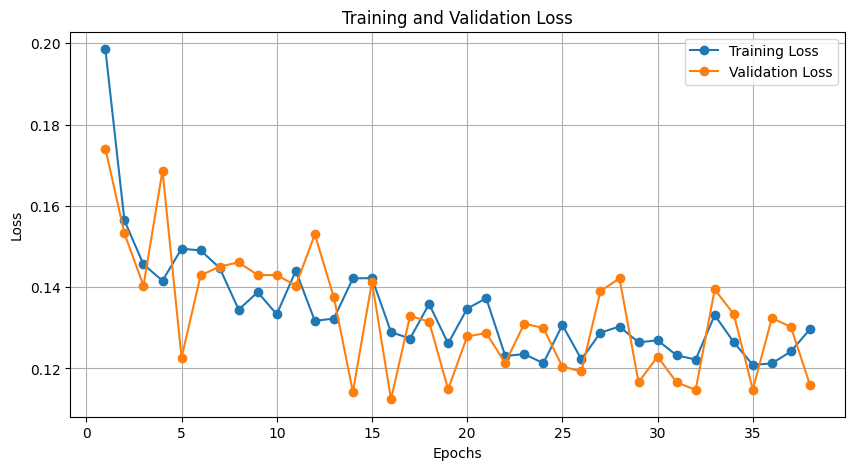

In [17]:

epochs = range(1, len(epoch_loss_train) + 1)
plt.figure(figsize=(10, 5))  
plt.plot(epochs, epoch_loss_train, label='Training Loss', marker='o')  
plt.plot(epochs, epoch_loss_val, label='Validation Loss', marker='o') 
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# should be done by loading the model

In [ ]:
def normalize_image(img):
    img_min = img.min()
    img_max = img.max()
    return (img - img_min) / (img_max - img_min)
def save_imgs(img,i):
    save_to="/kaggle/working/predicted"
    if(i==0):
        os.mkdir(save_to)
    img=img.detach().cpu().numpy()
    b=img.shape[0]
    img = np.transpose(img, (0,2,3,1)) 
    for j in range(b):
        img[j] = (normalize_image(img[j]) * 255)
        cv2.imwrite(os.path.join(save_to,str((b*i)+j)+".png"),img[j])
    
    

In [ ]:
import torch
from torch.cuda.amp import autocast, GradScaler

infer_loader = DataLoader(data_val, batch_size=100, shuffle=False, num_workers=4)
def show_img(img):
    img=img.detach().cpu().numpy()
    img = img.squeeze(0)
    img = np.transpose(img, (1, 2, 0)) 
    print(img.shape)
    img = (normalize_image(img) * 255).astype(np.uint8)
    plt.imshow(img)
    plt.show()

def perform_kmeans_clustering(data, n_clusters):
    data_matrix = torch.stack(data).numpy().reshape(-1, 64) 
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(data_matrix)
    cluster_labels = kmeans.labels_
    clustered_data = [[] for _ in range(n_clusters)]
    for idx, label in enumerate(cluster_labels):
        clustered_data[label].append(data[idx])

    return clustered_data

class inference(nn.Module):
    def __init__(self,gen_cluster=False):
        super().__init__() 
        trained_model_path="/kaggle/input/dl-ass2-part2/model_checkpoint.pth"
        trained_checkpoint=torch.load(trained_model_path)
        model_state_dict = trained_checkpoint["model_state_dict"]
        self.infer_diffusion=diffusion().to(device)
        self.infer_diffusion.load_state_dict(model_state_dict)
        self.infer_diffusion.eval()
        if(gen_cluster):
            final_slots=[]
            for i,(x,y) in enumerate(train_loader):
                x=x.to(device)
                slots,_=self.infer_diffusion.slot_model(x)
                for one in slots:
                    for slt in one:
                        final_slots.append(slt.detach().cpu())
                del(x)
    #             if(i==10):
    #                 break
            print("slots saved!!")
            clusters=perform_kmeans_clustering(final_slots,11)
            with open('slot_tensors.pkl', 'wb') as f:
                pickle.dump(clusters, f)
            print("clusters generated!!!")
        else:
            pass
            with open('/kaggle/input/clustered-slots-part2/slot_tensors.pkl', 'rb') as f:
                clusters=pickle.load(f)
        self.clusters=clusters
        ###################################
        beta_start = 0.0015
        beta_end = 0.0195
        betas=torch.linspace(beta_start, beta_end, 1000)
        self.sqrt_beta=torch.sqrt(betas)
        self.alphas = 1.0 - betas
        self.sqrt_aplha=torch.sqrt(self.alphas)
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - self.alphas_cumprod)
        
    def gen_img(self, n):
        time_embedding = time_embeddings().to(device)
        scaler = GradScaler()
        l_imgs = []
        for i,(x,y) in enumerate(infer_loader):
            b,_,_,_=x.shape
            x=x.to(device)
#             if(i==n):
#                 break
            print("batch : ", i)
#             slot = []
#             for j in range(11):
#                 slot.append(random.choice(self.clusters[j]))
#             slot = torch.stack(slot, dim=0).to(device).unsqueeze(0)
            slot,_=self.infer_diffusion.slot_model(x)
            t_prev = None
            t_nxt = None
            t_prev = torch.randn((b, 3, 32, 32), device=device)
            with torch.no_grad():
                for t in range(1000, 0, -1):
                    t_embed = time_embedding(t).to(device)
                    if t > 1:
                        z = torch.randn((b, 3, 32, 32), device=device)
                    else:
                        z = torch.zeros((b, 3, 32, 32), device=device)
                    t_nxt = self.infer_diffusion.unet_model(t_prev, slot, t_embed).permute(0, 3, 1, 2)
                    t_prev = ((t_prev - (((1 - self.alphas[t-1]) * t_nxt) / (self.sqrt_one_minus_alphas_cumprod[t-1]))) / (self.sqrt_aplha[t-1])) + (self.sqrt_beta[t-1] * z)
            vae_decoder_out = self.infer_diffusion.vae_model.decode(t_prev)
#             show_img(vae_decoder_out)
            save_imgs(vae_decoder_out,i)
#             l_imgs.append(vae_decoder_out)
        return l_imgs
            
            
infer=inference()

In [ ]:
o=infer.gen_img(1)

In [ ]:
def reshape_val(p):
    l=os.listdir(p)
    if os.path.exists("val"):
        os.rmdir("val")
    os.makedirs("val")
    path="/kaggle/working/val/"
    for i in range(len(l)):
        img_path=os.path.join(p,l[i])
        new_img=cv2.resize(cv2.imread(img_path),(128,128))
        cv2.imwrite(path+str(i)+".png",new_img)
reshape_val("/kaggle/input/deeplearning-ass2/dataset/images/val")


In [ ]:
val_data_path="/kaggle/input/dl-ass2-part2-fid-data/kaggle/working/val"
infered_path="/kaggle/input/dl-ass2-part2-fid-data/kaggle/working/predicted"
paths=[val_data_path,infered_path]
fid_value = calculate_fid_given_paths(paths, batch_size=50, device=device, dims=2048)
print(fid_value)

In [ ]:
b=2
val_loader = DataLoader(data_val, batch_size=b, shuffle=False, num_workers=4)
def calculate_ari():
    trained_model_path="/kaggle/input/dl-diffusion-2/model_2.pth"
    trained_checkpoint=torch.load(trained_model_path)
    model_state_dict = trained_checkpoint["model_state_dict"]
    infer_diffusion=diffusion().to(device)
    infer_diffusion.load_state_dict(model_state_dict)
    infer_diffusion.eval()
    
    ari=0
    for i,(x,y) in enumerate(tqdm(val_loader)):
        x=x.to(device)
        y=y.to(device)
#         y=normalize_image(y)*255
        slots,att_map=infer_diffusion.slot_model(x)
        print(att_map.shape)
        att_map=att_map.reshape(b,32,32,11).permute(0,3,1,2)
        ari+=torch.sum(adjusted_rand_index(y,att_map))
    return(ari.item()/len(val_loader))
    

In [ ]:
ari=calculate_ari()
print(ari)